In [27]:
import os
import numpy as np
from os.path import join
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv

import data
import util
import models

In [9]:
unnorm = util.UnNormalize([0.507, 0.487, 0.441], [0.267, 0.256, 0.276])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyper-parameter
bs = 128
n_classes = 100
mc = 10

In [4]:
# data loader
test_loader = data.get_cifar100_test_loader(bs)

In [5]:
_, svhn_loader = data.get_svhn_loader(bs)

Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
sns.set_style(style='darkgrid')

### Load pre-trained model

In [10]:
# load pre-trained model
model = models.ResNet50_modified(n_classes, mc)
model.to(device)
runs_dir = join('runs','resnet_aleo')
ckpt = torch.load(join(runs_dir, 'model_ckpt.pth'))
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

### Out-of-distribution comparison

#### CIFAR100 vs SVHN

In [11]:

model.eval()
aleo_cifar = []
epis_cifar = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        B = inputs.size(0)
        logprob,mu,rho = model(inputs)
        pred = mu.max(1)[1]
        aleo_cifar += rho[torch.arange(B), pred].div(2).exp().cpu().detach().tolist()
        epis_cifar += logprob.exp().mul(logprob).sum(dim=1).mul(-1).cpu().detach().tolist()

model.eval()
aleo_svhn = []
epis_svhn = []
with torch.no_grad():
    for inputs, targets in svhn_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        B = inputs.size(0)
        logprob,mu,rho = model(inputs)
        pred = mu.max(1)[1]
        aleo_svhn += rho[torch.arange(B), pred].div(2).exp().cpu().detach().tolist()
        epis_svhn += logprob.exp().mul(logprob).sum(dim=1).mul(-1).cpu().detach().tolist()

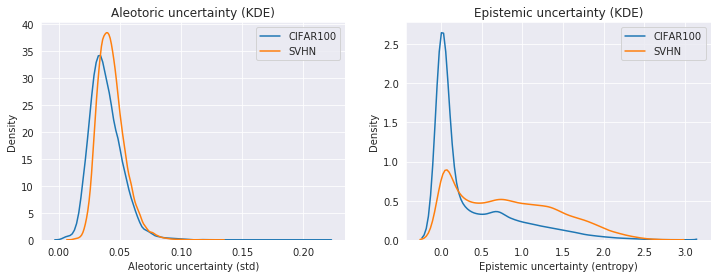

In [12]:
_, ax = plt.subplots(1, 2, figsize=(12,4))

sns.kdeplot(aleo_cifar, label='CIFAR100', ax=ax[0])
sns.kdeplot(aleo_svhn, label='SVHN', ax=ax[0])
ax[0].legend(loc='best')
ax[0].set_title('Aleotoric uncertainty (KDE)')
ax[0].set_xlabel('Aleotoric uncertainty (std)')
ax[0].set_ylabel('Density')

sns.kdeplot(epis_cifar, label='CIFAR100', ax=ax[1])
sns.kdeplot(epis_svhn, label='SVHN', ax=ax[1])
ax[1].legend(loc='best')
ax[1].set_title('Epistemic uncertainty (KDE)')
ax[1].set_xlabel('Epistemic uncertainty (entropy)')
ax[1].set_ylabel('Density')

plt.show()

#### Rotation 0 vs else

In [56]:
aleos = []
episs = []
for r in tqdm_notebook(range(0,360, 30)):
    # data loader
    test_loader = data.get_cifar100_test_loader(bs, r)
    
    aleo = []
    epis = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            B = inputs.size(0)
            logprob,mu,rho = model(inputs)
            pred = mu.max(1)[1]
            aleo += rho[torch.arange(B), pred].div(2).exp().cpu().detach().tolist()
            epis += logprob.exp().mul(logprob).sum(dim=1).mul(-1).cpu().detach().tolist()
    aleos.append(np.mean(aleo))
    episs.append(np.mean(epis))

/home/ibn/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


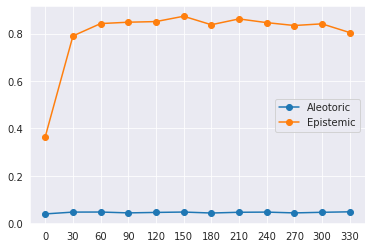

In [59]:
ax = plt.subplot()
xtick = np.arange(len(nlls))
ax.plot(xtick, aleos, '-o', label='Aleotoric')
ax.plot(xtick, episs, '-o', label='Epistemic')
ax.set_xticks(xtick)
ax.set_xticklabels([f'{i}' for i in np.arange(0,360,30)])
ax.legend(loc='best')
# ax.set_title('Proper scoring rule: NLL')
# ax.set_xlabel('Rotate angle')
# ax.set_ylabel('NLL')

### In-distribution comparison by calibration

In [13]:
# load pre-trained baseline model
model_b = models.ResNet50()
model_b.to(device)
runs_dir = join('runs','resnet')
ckpt = torch.load(join(runs_dir, 'model_ckpt.pth'))
model_b.load_state_dict(ckpt['model'])

<All keys matched successfully>

#### Expected Calibration Error (ECE)

In [22]:
model.eval()
labels_true, labels_pred, preds = [], [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        B = inputs.size(0)
        logprob,mu,_ = model(inputs)
#         preds += torch.softmax(mu, dim=1).max(1)[0].cpu().tolist()
#         labels_pred += mu.max(1)[1].cpu().tolist()
        preds += logprob.exp().max(1)[0].cpu().tolist()
        labels_pred += logprob.max(1)[1].cpu().tolist()
        labels_true += targets.cpu().tolist()
labels_true, labels_pred, preds = np.array(labels_true), np.array(labels_pred), np.array(preds)

accs = []
ces = []
for bin_start in np.arange(0.1,1,0.1):
    # indices within bin range
    bin_idxs = np.where((preds>bin_start) * (preds<(bin_start+0.1)))[0]

    # accuracy
    acc = np.equal(labels_pred[bin_idxs], labels_true[bin_idxs]).sum() / len(bin_idxs)
    accs.append(acc)
    
    # calibration error
    ce = preds[bin_idxs].mean()
    ces.append(ce)

In [24]:
model_b.eval()
labels_true_b, labels_pred_b, preds_b = [], [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        B = inputs.size(0)
        logits,_,_ = model_b(inputs)
        preds_b += torch.softmax(logits, dim=1).max(1)[0].cpu().tolist()
        labels_pred_b += logits.max(1)[1].cpu().tolist()
        labels_true_b += targets.cpu().tolist()
labels_true_b, labels_pred_b, preds_b = np.array(labels_true_b), np.array(labels_pred_b), np.array(preds_b)

accs_b = []
ces_b = []
for bin_start in np.arange(0.1,1,0.1):
    # indices within bin range
    bin_idxs = np.where((preds_b>bin_start) * (preds_b<(bin_start+0.1)))[0]

    # accuracy
    acc = np.equal(labels_pred_b[bin_idxs], labels_true_b[bin_idxs]).sum() / len(bin_idxs)
    accs_b.append(acc)
    
    # calibration error
    ce = preds_b[bin_idxs].mean()
    ces_b.append(ce)

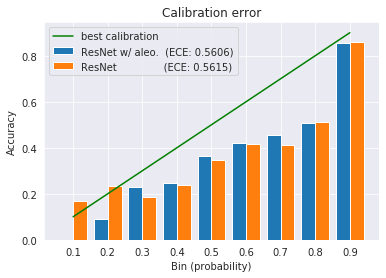

In [26]:
n = 1  # This is our first dataset (out of 2)
t = 2 # Number of dataset
d = 6 # Number of sets of bars
w = 0.8 # Width of each bar
def create_x(t, w, n, d):
    return [t*x + w*n for x in range(d)]

ax = plt.subplot()
value_x1 = create_x(2, 0.8, 1, len(accs))
value_x2 = create_x(2, 0.8, 2, len(accs_b))
middle_x = [(a+b)/2 for (a,b) in zip(value_x1, value_x2)]
ax.set_xticks(middle_x)
ax.set_xticklabels([f'{i:.01f}' for i in np.arange(0.1,1,0.1)])
plt.bar(value_x1, accs, label=f'ResNet w/ aleo.  (ECE: {np.mean(ces):.04f})')
plt.bar(value_x2, accs_b, label=f'ResNet               (ECE: {np.mean(ces_b):.04f})')
plt.plot(middle_x,np.arange(0.1,1,0.1), color='g', label='best calibration')
plt.legend(loc='best')
plt.title('Calibration error')
plt.xlabel('Bin (probability)')
plt.ylabel('Accuracy')

plt.show()

#### Proper scoring rule (NLL, Brier score)

In [33]:
nlls, briers = [], []
nlls_b, briers_b = [], []
for r in tqdm_notebook(range(0,360, 30)):
    # data loader
    test_loader = data.get_cifar100_test_loader(bs, r)
    
    # resnet w/ aleotoric
    model.eval()
    nll = 0.
    brier = 0.
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            B = inputs.size(0)
            logprob,mu,_ = model(inputs)
            nll += F.nll_loss(logprob, targets, reduction='sum').cpu().item()
            brier += (logprob.exp().pow(2).sum(dim=1) + 1 - logprob.exp()[range(B), targets].mul(2)).sum().item()
    nlls.append(nll / len(test_loader.dataset))
    briers.append(brier / len(test_loader.dataset))
    
    # resnet (baseline)
    model_b.eval()
    nll_b = 0.
    brier_b = 0.
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            B = inputs.size(0)
            logits,_,_ = model_b(inputs)
            probs = F.softmax(logits, dim=1)
            nll_b += F.cross_entropy(logits, targets, reduction='sum').cpu().item()
            brier_b += (probs.pow(2).sum(dim=1) + 1 - probs[range(B), targets].mul(2)).sum().item()
    nlls_b.append(nll_b / len(test_loader.dataset))
    briers_b.append(brier_b / len(test_loader.dataset))
    

/home/ibn/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


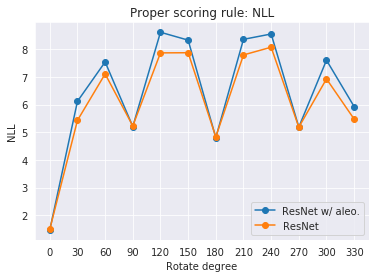

In [43]:
xtick = np.arange(len(nlls))
ax = plt.subplot()
ax.plot(xtick, nlls, '-o', label='ResNet w/ aleo.')
ax.plot(xtick, nlls_b, '-o', label='ResNet')
ax.set_xticks(xtick)
ax.set_xticklabels([f'{i}' for i in np.arange(0,360,30)])
ax.legend(loc='best')
ax.set_title('Proper scoring rule: NLL')
ax.set_xlabel('Rotate degree')
ax.set_ylabel('NLL')
plt.show()

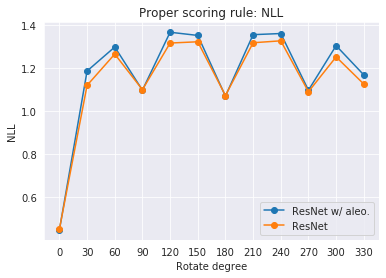

In [45]:
ax = plt.subplot()
plt.plot(np.arange(len(briers)), briers, '-o', label='ResNet w/ aleo.')
plt.plot(np.arange(len(briers)), briers_b, '-o', label='ResNet')
ax.set_xticks(xtick)
ax.set_xticklabels([f'{i}' for i in np.arange(0,360,30)])
ax.legend(loc='best')
ax.set_title('Proper scoring rule: NLL')
ax.set_xlabel('Rotate degree')
ax.set_ylabel('NLL')
plt.show()

In [18]:
model.eval()
nll = 0.
brier = 0.
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        B = inputs.size(0)
        logprob,mu,_ = model(inputs)
        nll += F.nll_loss(logprob, targets, reduction='sum').cpu().item()
        brier += (logprob.exp().pow(2).sum(dim=1) + 1 - logprob.exp()[range(B), targets].mul(2)).sum().item()
nll = nll / len(test_loader.dataset)
brier = brier / len(test_loader.dataset)

In [19]:
model_b.eval()
nll_b = 0.
brier_b = 0.
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        B = inputs.size(0)
        logits,_,_ = model_b(inputs)
        probs = F.softmax(logits, dim=1)
        nll_b += F.cross_entropy(logits, targets, reduction='sum').cpu().item()
        brier_b += (probs.pow(2).sum(dim=1) + 1 - probs[range(B), targets].mul(2)).sum().item()
nll_b = nll_b / len(test_loader.dataset)
brier_b = brier_b / len(test_loader.dataset)

In [20]:
brier

0.4477806683540344

In [21]:
brier_b

0.45213211135864256

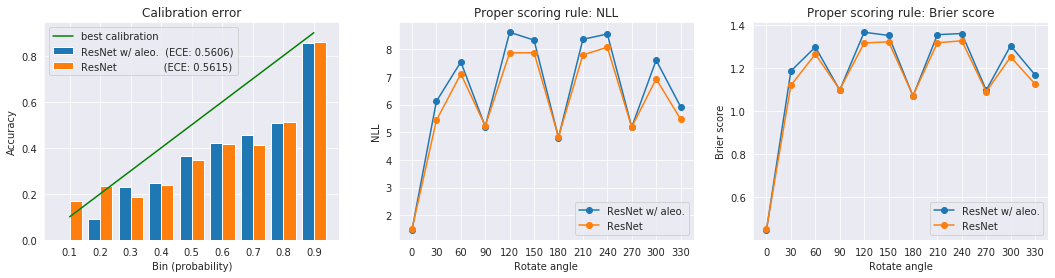

In [55]:
_, ax = plt.subplots(1,3, figsize=(18,4))
value_x1 = create_x(2, 0.8, 1, len(accs))
value_x2 = create_x(2, 0.8, 2, len(accs_b))
middle_x = [(a+b)/2 for (a,b) in zip(value_x1, value_x2)]
ax[0].set_xticks(middle_x)
ax[0].set_xticklabels([f'{i:.01f}' for i in np.arange(0.1,1,0.1)])
ax[0].bar(value_x1, accs, label=f'ResNet w/ aleo.  (ECE: {np.mean(ces):.04f})')
ax[0].bar(value_x2, accs_b, label=f'ResNet               (ECE: {np.mean(ces_b):.04f})')
ax[0].plot(middle_x,np.arange(0.1,1,0.1), color='g', label='best calibration')
ax[0].legend(loc='best')
ax[0].set_title('Calibration error')
ax[0].set_xlabel('Bin (probability)')
ax[0].set_ylabel('Accuracy')

xtick = np.arange(len(nlls))
ax[1].plot(xtick, nlls, '-o', label='ResNet w/ aleo.')
ax[1].plot(xtick, nlls_b, '-o', label='ResNet')
ax[1].set_xticks(xtick)
ax[1].set_xticklabels([f'{i}' for i in np.arange(0,360,30)])
ax[1].legend(loc='best')
ax[1].set_title('Proper scoring rule: NLL')
ax[1].set_xlabel('Rotate angle')
ax[1].set_ylabel('NLL')

ax[2].plot(np.arange(len(briers)), briers, '-o', label='ResNet w/ aleo.')
ax[2].plot(np.arange(len(briers)), briers_b, '-o', label='ResNet')
ax[2].set_xticks(xtick)
ax[2].set_xticklabels([f'{i}' for i in np.arange(0,360,30)])
ax[2].legend(loc='best')
ax[2].set_title('Proper scoring rule: Brier score')
ax[2].set_xlabel('Rotate angle')
ax[2].set_ylabel('Brier score')

plt.show()